# **S♻️MPIS**

sumber:
1. https://www.kaggle.com/datasets/aashidutt3/waste-segregation-image-dataset
2. https://www.kaggle.com/datasets/aashidutt3/waste-segregation-image-dataset

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
!git clone https://github.com/Sampis-CodingCamp/dataset.git

Cloning into 'dataset'...
remote: Enumerating objects: 17345, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 17345 (delta 1), reused 90 (delta 1), pack-reused 17253 (from 2)
Receiving objects: 100% (17345/17345), 812.05 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Updating files: 100% (8000/8000), done.


In [ ]:
folder_path = "/content/dataset"

# Cek isi folder
for filename in os.listdir(folder_path):
    print(filename)


kaca
kayu
plastik
kertas
pakaian
.git
makanan
elektronik
logam


In [ ]:
import os

# Path ke folder dataset
dataset_path = "/content/dataset"

# Menampung total
total = 0

print("Jumlah gambar per kelas:\n")

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    num_images = len(os.listdir(class_path))
    total += num_images
    print(f"{class_name}: {num_images} gambar")

print(f"\nTotal gambar di semua kelas: {total}")


Jumlah gambar per kelas:

kaca: 1000 gambar
kayu: 1000 gambar
plastik: 1000 gambar
kertas: 1000 gambar
pakaian: 1000 gambar
.git: 11 gambar
makanan: 1000 gambar
elektronik: 1000 gambar
logam: 1000 gambar

Total gambar di semua kelas: 8011


In [ ]:
import shutil
import os

# Path ke folder .git
git_folder_path = "/content/dataset/.git"

# Memeriksa apakah folder .git ada, lalu menghapusnya
if os.path.exists(git_folder_path) and os.path.isdir(git_folder_path):
    shutil.rmtree(git_folder_path)  # Menghapus folder .git beserta isinya
    print(".git folder telah dihapus.")
else:
    print(".git folder tidak ditemukan.")


.git folder telah dihapus.


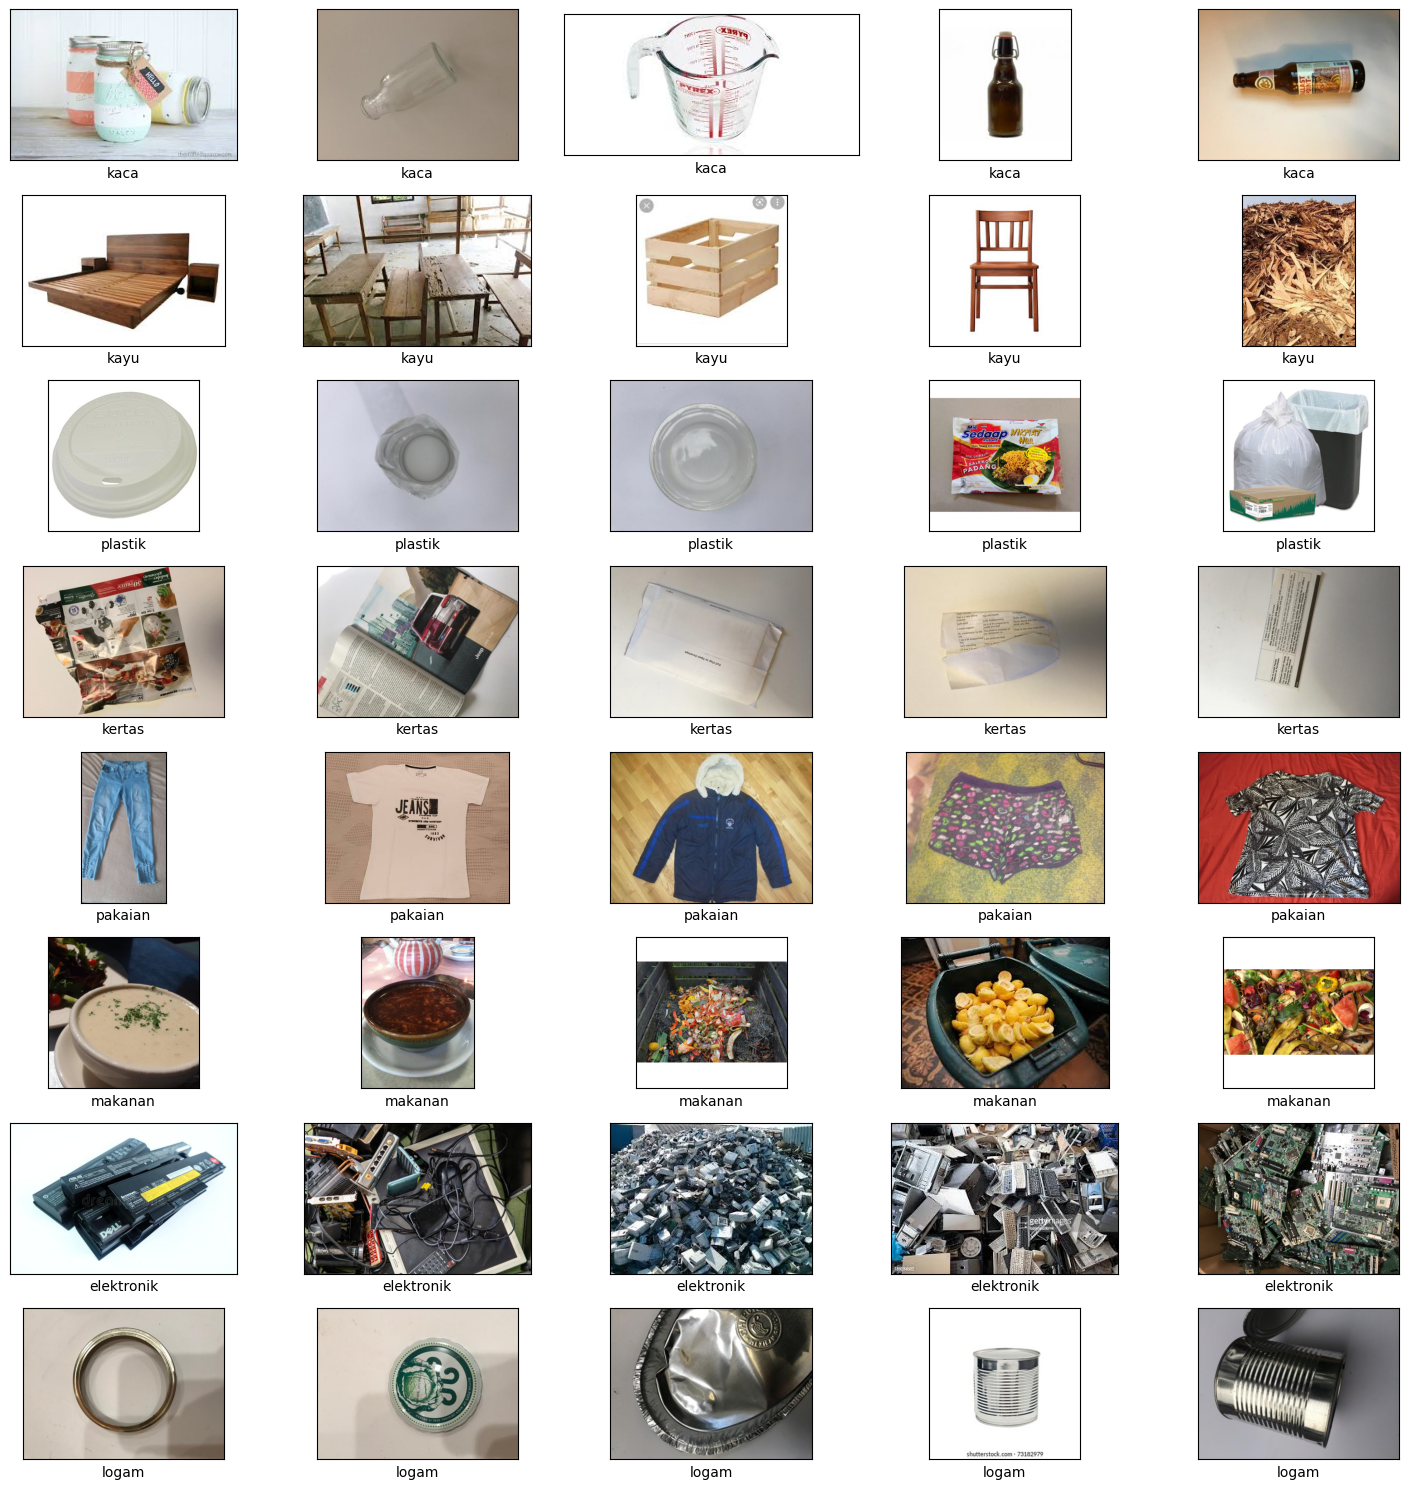

In [ ]:
sampis_image = {}
path_sub = "/content/dataset"

for class_name in os.listdir(path_sub):
    class_path = os.path.join(path_sub, class_name)
    sampis_image[class_name] = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Memastikan kita memiliki cukup gambar untuk dipilih
fig, axs = plt.subplots(len(sampis_image), 5, figsize=(15, 15))

for i, class_name in enumerate(sampis_image.keys()):
    # Pastikan ada setidaknya 5 gambar dalam kelas ini
    images = sampis_image[class_name]
    if len(images) >= 5:
        images = np.random.choice(images, 5, replace=False)
    else:
        images = np.random.choice(images, len(images), replace=False)  # Ambil semua gambar jika kurang dari 5

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

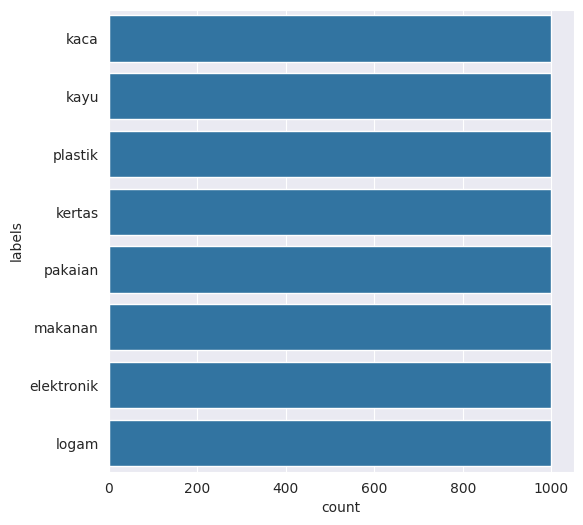

In [ ]:
# Define source path
sampis_path = "/content/dataset"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(sampis_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_data = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_data['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Fungsi untuk mendapatkan resolusi gambar
def get_image_resolution(filepath):
    try:
        with Image.open(filepath) as img:
            return img.size  # (width, height)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return (None, None)

In [ ]:
# Path utama ke dataset
path = "dataset/"

# Daftar untuk menyimpan data
data = []

# Iterasi melalui setiap file di dalam path
for class_name in os.listdir(path):  # loop through class name folders
    class_path = os.path.join(path, class_name)  # Menggunakan 'path' bukan 'path_sub'
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            # Check if it is a file and has a supported image extension
            if os.path.isfile(os.path.join(class_path, filename)) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                label = class_name  # Use this if class names are folder names
                filepath = os.path.join(class_path, filename)
                data.append({'filename': filename, 'filepath': filepath, 'label': label})

# Membuat DataFrame
dataset_df = pd.DataFrame(data)

# Menambahkan kolom resolusi ke dataset_df
dataset_df['resolution'] = dataset_df['filepath'].apply(get_image_resolution)

# Menampilkan hasil
dataset_df

,filename,filepath,label,resolution
0,white-glass11.jpg,dataset/kaca/white-glass11.jpg,kaca,"(512, 384)"
1,R_5330.jpg,dataset/kaca/R_5330.jpg,kaca,"(225, 225)"
2,glass (210).jpg,dataset/kaca/glass (210).jpg,kaca,"(800, 800)"
3,brown-glass357.jpg,dataset/kaca/brown-glass357.jpg,kaca,"(225, 225)"
4,green-glass629.jpg,dataset/kaca/green-glass629.jpg,kaca,"(310, 163)"
...,...,...,...,...
7995,metal8 (2).jpg,dataset/logam/metal8 (2).jpg,logam,"(512, 384)"
7996,kaleng (7).png,dataset/logam/kaleng (7).png,logam,"(256, 256)"
7997,metal173.jpg,dataset/logam/metal173.jpg,logam,"(512, 384)"
7998,kaleng (47).png,dataset/logam/kaleng (47).png,logam,"(256, 256)"


In [ ]:
dataset_df['resolution'].value_counts()

,count
resolution,
"(512, 384)",1771
"(256, 256)",761
"(225, 225)",662
"(400, 533)",436
"(275, 183)",327
...,...
"(570, 612)",1
"(200, 253)",1
"(500, 448)",1


### Data Preprocessing

In [ ]:
from PIL import Image, ImageFile
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

source_folder = 'dataset'
output_folder = 'sampis_datasets'

valid_extensions = ('.jpg', '.jpeg', '.jfif', '.png', '.bmp', '.webp')

os.makedirs(output_folder, exist_ok=True)

for class_name in os.listdir(source_folder):
    class_path = os.path.join(source_folder, class_name)
    output_class_path = os.path.join(output_folder, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        if not img_name.lower().endswith(valid_extensions):
            print(f"Skipped unsupported format: {img_name}")
            continue

        img_path = os.path.join(class_path, img_name)
        output_path = os.path.join(output_class_path, img_name)

        try:
            with Image.open(img_path) as img:
                if img.mode in ('RGBA', 'LA', 'P'):
                    img = img.convert('RGB')
                img = img.resize((416, 416))
                img.save(output_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Konfigurasi augmentasi data untuk training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalisasi pixel
    rotation_range=20,           # Rotasi acak
    width_shift_range=0.2,       # Geser horizontal
    height_shift_range=0.2,      # Geser vertikal
    shear_range=0.15,            # Distorsi potong
    zoom_range=0.15,             # Zoom in/out acak
    horizontal_flip=True,        # Membalik horizontal
    fill_mode='nearest',         # Isi pixel kosong
    validation_split=0.2         # Pisahkan data validasi
)

# Generator untuk training dan validasi
train_generator = train_datagen.flow_from_directory(
    'sampis_datasets',
    target_size=(416, 416),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    'sampis_datasets',
    target_size=(416, 416),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


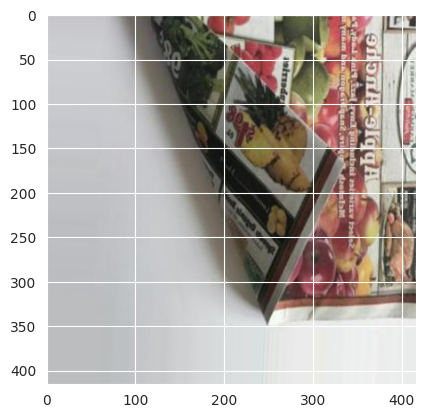

In [ ]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(train_generator)  # ambil batch data
plt.imshow(x_batch[14])                    # tampilkan gambar pertama di batch
plt.show()


### Split Dataset

In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= dataset_df['filepath']
y= dataset_df['label']

# Tahap 1: Split data ke train+val dan test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

# Tahap 2: Split lagi train+val menjadi train dan val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=300)  # 0.25 x 0.8 = 0.2

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_train = pd.DataFrame({'filepath':X_train,'label':y_train,'set':'train'})
df_test = pd.DataFrame({'filepath':X_test,'label':y_test,'set':'test'})
df_val = pd.DataFrame({'filepath':X_val,'label':y_val,'set':'val'})

In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'label']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    label     
test   elektronik    222
       kaca          212
       kayu          191
       kertas        162
       logam         179
       makanan       210
       pakaian       215
       plastik       209
train  elektronik    568
       kaca          597
       kayu          620
       kertas        627
       logam         621
       makanan       590
       pakaian       570
       plastik       607
val    elektronik    210
       kaca          191
       kayu          189
       kertas        211
       logam         200
       makanan       200
       pakaian       215
       plastik       184
dtype: int64 


                             filepath    label    set
6161   dataset/pakaian/clothes603.jpg  pakaian   test
2484     dataset/plastik/OIP (9).jpeg  plastik  train
2394        dataset/kaca/glass399.jpg     kaca  train
3633      dataset/kertas/paper412.jpg   kertas  train
3315  dataset/kertas/cardboard685.jpg   kertas  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "sampis_datasets"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['filepath']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['label'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['label'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['label']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['label'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Modelling

In [ ]:
# Define training and test directories
train_dir = "Dataset-Final/train/"
test_dir = "Dataset-Final/test/"
val_dir = "Dataset-Final/val/"

In [ ]:
# Custom Callback: berhenti jika akurasi sudah bagus
class StopAtTargetAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.95:
            print("\n\n Target akurasi tercapai. Menghentikan training...\n")
            self.model.stop_training = True

# Gabung semua callback
def callback_model():
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        StopAtTargetAccuracy()
    ]

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def sampis_model_transfer():
    TRAIN_DIR = 'Dataset-Final/train'
    VAL_DIR = 'Dataset-Final/val'
    TEST_DIR = 'Dataset-Final/test'

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    num_classes = train_generator.num_classes

    # Load base model MobileNetV2
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze layer dasar

    # Head classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_generator,
        epochs=150,
        validation_data=val_generator,
        callbacks=callback_model(),
        verbose=1
    )

    return model, history

In [ ]:
model, history = sampis_model_transfer()

Found 4800 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 87s 498ms/step - accuracy: 0.4767 - loss: 1.4817 - val_accuracy: 0.8350 - val_loss: 0.4893 - learning_rate: 5.0000e-04
Epoch 2/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 452ms/step - accuracy: 0.7819 - loss: 0.6225 - val_accuracy: 0.8644 - val_loss: 0.4140 - learning_rate: 5.0000e-04
Epoch 3/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 69s 460ms/step - accuracy: 0.8178 - loss: 0.4975 - val_accuracy: 0.8731 - val_loss: 0.3658 - learning_rate: 5.0000e-04
Epoch 4/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 446ms/step - accuracy: 0.8456 - loss: 0.4360 - val_accuracy: 0.8706 - val_loss: 0.3623 - learning_rate: 5.0000e-04
Epoch 5/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 449ms/step - accuracy: 0.8695 - loss: 0.3777 - val_accuracy: 0.8850 - val_loss: 0.3456 - learning_rate: 5.0000e-04
Epoch 6/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 68s 453ms/step - accuracy: 0.8804 - loss: 0.3602 - val_accuracy: 0.8856 - val_loss: 0.3438 - learning_rate: 5.0000e-04
Epoch 7/150
150/150 ━━━━━━━━━━━━━━━━━━━━

## Evaluasi dan Visualisasi

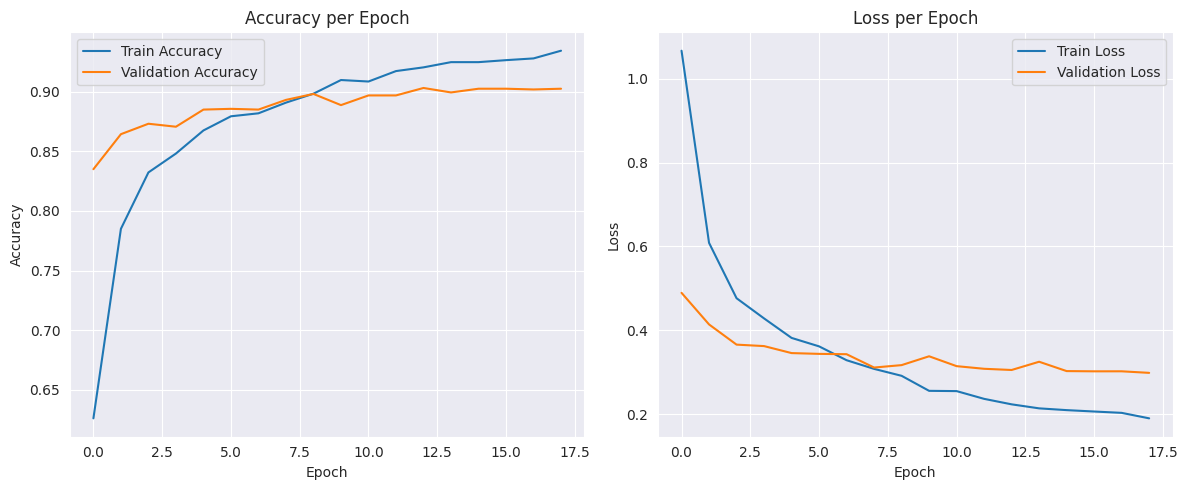

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

### Saved Model

In [ ]:
# Simpan model ke format SavedModel
model.export('/content/saved_model')

# Kompres folder
import shutil
from google.colab import files

shutil.make_archive('/content/saved_model', 'zip', '/content/saved_model')

# Download file zip
files.download('/content/saved_model.zip')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  136665938722896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938796112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938799568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665982322448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665982326288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665982326096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938801680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938797072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938800336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136665938793424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1366659387

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TFJS

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/model_tfjs

2025-06-04 03:57:54.763625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749009474.798509    7716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749009474.823662    7716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-04 03:58:02.991362: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749009482.991527    7716 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
shutil.make_archive('/content/model_tfjs', 'zip', '/content/model_tfjs')

# Download file zip
files.download('/content/model_tfjs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TF-Lite

In [ ]:
# Load the TensorFlow SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the converted model to a file
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
class_labels = ["elektronik", "kaca", "kayu", "kertas", "logam", "makanan", "pakaian", "plastik"]

with open('/content/label.txt', 'w') as f:
    for label in class_labels:
        f.write(f"{label}\n")

## Inference (Optional)

Saving artworks-YDQOy2Pru5CA2rhs-x1uzgA-t500x500.jpg to artworks-YDQOy2Pru5CA2rhs-x1uzgA-t500x500.jpg


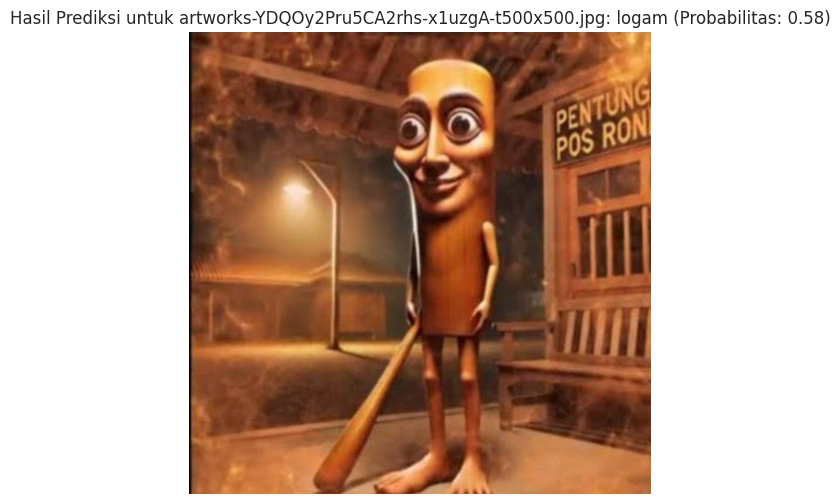

In [ ]:
import io

# Unggah gambar baru
uploaded_files = files.upload()

# Inisialisasi model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='/content/model.tflite')
interpreter.allocate_tensors()

# Ambil detail input dan output model
input_info = interpreter.get_input_details()
output_info = interpreter.get_output_details()

# Fungsi untuk memproses gambar sebelum prediksi
def prepare_image(img, size):
    # Jika diperlukan, Anda bisa melakukan crop di sini (misalnya fokus ke bagian tengah gambar)
    width, height = img.size
    left = width * 0.2  # Sesuaikan area cropping sesuai kebutuhan
    top = height * 0.2
    right = width * 0.8
    bottom = height * 0.8
    img = img.crop((left, top, right, bottom))  # Crop gambar untuk fokus ke area pisang

    # Resize gambar ke ukuran input model
    img = img.resize(size)
    img_array = np.array(img).astype('float32') / 255.0  # Normalisasi
    return np.expand_dims(img_array, axis=0)  # Tambah dimensi batch

# Baca label kelas dari file
with open('/content/label.txt', 'r') as label_file:
    labels = label_file.read().splitlines()

# Ukuran input yang diharapkan oleh model
input_size = (224, 224)  # Ukuran input model yang baru

# Prediksi untuk setiap gambar yang diunggah
for name in uploaded_files.keys():
    img = Image.open(io.BytesIO(uploaded_files[name]))

    # Proses gambar untuk prediksi dengan cropping dan resize
    processed_img = prepare_image(img, input_size)

    # Masukkan data ke dalam model
    interpreter.set_tensor(input_info[0]['index'], processed_img)

    # Jalankan model
    interpreter.invoke()

    # Ambil hasil prediksi
    output_data = interpreter.get_tensor(output_info[0]['index'])
    predicted_index = np.argmax(output_data)
    predicted_label = labels[predicted_index]

    # Tampilkan gambar dan hasil prediksi
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Hasil Prediksi untuk {name}: {predicted_label} (Probabilitas: {output_data[0][predicted_index]:.2f})")
    plt.axis('off')
    plt.show()
